# Prototyping the Analysis Pipeline for the [NeuroPredict]

_Write in this notebook all the stages required to prototype your data analysis pipeline according to the project instructions._

## Libraries/Dependencies

In [ ]:
# Import necessary libraries

import warnings
warnings.filterwarnings("ignore")

import textwrap
import optuna
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import catboost as cb
from scipy.optimize import minimize
import networkx as nx
import time
import warnings
import seaborn as sns
from matplotlib.lines import Line2D
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

## Dataset Overview

In [71]:
# load dataset
df_cat = pd.read_excel('../data/raw_data/TRAIN/TRAIN_CATEGORICAL_METADATA_new.xlsx')
df_Q = pd.read_excel('../data/raw_data/TRAIN/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
df_sol = pd.read_excel('../data/raw_data/TRAIN/TRAINING_SOLUTIONS.xlsx')


In [70]:
# load data dictionary
dict_df = pd.read_excel('../data/raw_data/Data Dictionary.xlsx', sheet_name='Dictionary')

def get_var_info(field_name):
    """get instrument and description via variable name"""
    row = dict_df.loc[dict_df["Field"] == field_name]
    if row.empty:
        return f"⚠️ '{field_name}' not found in dictionary."
    return {
        "instrument": row["Instrument"].values[0],
        "description": row["Description"].values[0]
    }


In [72]:
# merge three dataset
overall_df = df_cat.merge(df_Q, on = "participant_id", how = "inner").merge(df_sol, on = "participant_id", how = "inner")
overall_df.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN,...,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127,1,0
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0,...,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN,1,0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN,...,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381,0,1
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0,...,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553,0,1
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN,...,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574,1,0


In [60]:
#adjust variable name
dict_df['Field'] = dict_df['Field'].replace({'MRI_Track,Age_at_Scan': 'MRI_Track_Age_at_Scan'})
print (dict_df['Field'])

0                                  NaN
1                       participant_id
2                        EHQ_EHQ_Total
3                 ColorVision_CV_Score
4                       APQ_P_APQ_P_CP
5                       APQ_P_APQ_P_ID
6                      APQ_P_APQ_P_INV
7                      APQ_P_APQ_P_OPD
8                       APQ_P_APQ_P_PM
9                       APQ_P_APQ_P_PP
10            SDQ_SDQ_Conduct_Problems
11          SDQ_SDQ_Difficulties_Total
12          SDQ_SDQ_Emotional_Problems
13               SDQ_SDQ_Externalizing
14           SDQ_SDQ_Generating_Impact
15               SDQ_SDQ_Hyperactivity
16               SDQ_SDQ_Internalizing
17               SDQ_SDQ_Peer_Problems
18                   SDQ_SDQ_Prosocial
19               MRI_Track_Age_at_Scan
20                                 NaN
21                                 NaN
22                      participant_id
23             Basic_Demos_Enroll_Year
24              Basic_Demos_Study_Site
25    PreInt_Demos_Fam_Ch

In [61]:
#check the number of rows and columns
num_rows, num_columns = overall_df.shape
print("Data Overlook:")
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}\n")

# Count duplicate rows in dataset
overall_df_duplicates = overall_df.duplicated().sum()
print(f"Number of duplicate rows in merged dataset: {overall_df_duplicates}")

Data Overlook:
Number of Rows: 1213
Number of Columns: 30

Number of duplicate rows in merged dataset: 0


In [62]:
# Creating a table for missing values, unique values and data types of the features

missing_values_overall = pd.DataFrame({
    'Feature': overall_df.columns,
    'No. of Missing Values': overall_df.isnull().sum().values,
    '% of Missing Values': (overall_df.isnull().sum().values / len(overall_df) * 100)
})

unique_values_overall = pd.DataFrame({
    'Feature': overall_df.columns,
    'No. of Unique Values': overall_df.nunique().values
})

feature_types_overall = pd.DataFrame({
    'Feature': overall_df.columns,
    'DataType': overall_df.dtypes
})

merged_overall_df = pd.merge(missing_values_overall, unique_values_overall, on='Feature', how='left')
merged_overall_df = pd.merge(merged_overall_df, feature_types_overall, on='Feature', how='left')

merged_overall_df.style.background_gradient(cmap='viridis')

,Feature,No. of Missing Values,% of Missing Values,No. of Unique Values,DataType
0,participant_id,0,0.000000,1213,object
1,Basic_Demos_Enroll_Year,0,0.000000,6,int64
2,Basic_Demos_Study_Site,0,0.000000,4,int64
3,PreInt_Demos_Fam_Child_Ethnicity,43,3.544930,4,float64
4,PreInt_Demos_Fam_Child_Race,54,4.451772,10,float64
5,MRI_Track_Scan_Location,3,0.247321,4,float64
6,Barratt_Barratt_P1_Edu,15,1.236603,7,float64
7,Barratt_Barratt_P1_Occ,31,2.555647,10,float64
8,Barratt_Barratt_P2_Edu,198,16.323166,7,float64
9,Barratt_Barratt_P2_Occ,222,18.301731,10,float64


In [63]:
print('Description of all the numerical columns present in the overall dataset')
overall_df.describe().T.style.background_gradient(cmap='viridis')

Description of all the numerical columns present in the overall dataset


,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,1213.000000,2017.652102,1.122522,2015.000000,2017.000000,2018.000000,2019.000000,2020.000000
Basic_Demos_Study_Site,1213.000000,2.014839,1.135147,1.000000,1.000000,1.000000,3.000000,4.000000
PreInt_Demos_Fam_Child_Ethnicity,1170.000000,0.435897,0.693174,0.000000,0.000000,0.000000,1.000000,3.000000
PreInt_Demos_Fam_Child_Race,1159.000000,2.177739,3.204782,0.000000,0.000000,1.000000,2.000000,11.000000
MRI_Track_Scan_Location,1210.000000,2.294215,0.750660,1.000000,2.000000,2.000000,3.000000,4.000000
Barratt_Barratt_P1_Edu,1198.000000,17.862270,3.505608,3.000000,15.000000,18.000000,21.000000,21.000000
Barratt_Barratt_P1_Occ,1182.000000,25.545685,16.757043,0.000000,5.000000,30.000000,40.000000,45.000000
Barratt_Barratt_P2_Edu,1015.000000,16.876847,3.929558,3.000000,15.000000,18.000000,21.000000,21.000000
Barratt_Barratt_P2_Occ,991.000000,30.257316,13.901144,0.000000,20.000000,35.000000,40.000000,45.000000
EHQ_EHQ_Total,1200.000000,59.514750,49.744631,-100.000000,46.670000,77.800000,94.470000,100.000000


## Exploratory Data Analysis

In [33]:
categorical_variables = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ',
'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Generating_Impact',
'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']

numerical_variables = ['EHQ_EHQ_Total', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM',
'APQ_P_APQ_P_PP', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing', 'MRI_Track_Age_at_Scan']

target_variables = ['ADHD_Outcome', 'Sex_F']

### Numerical Feature Analysis

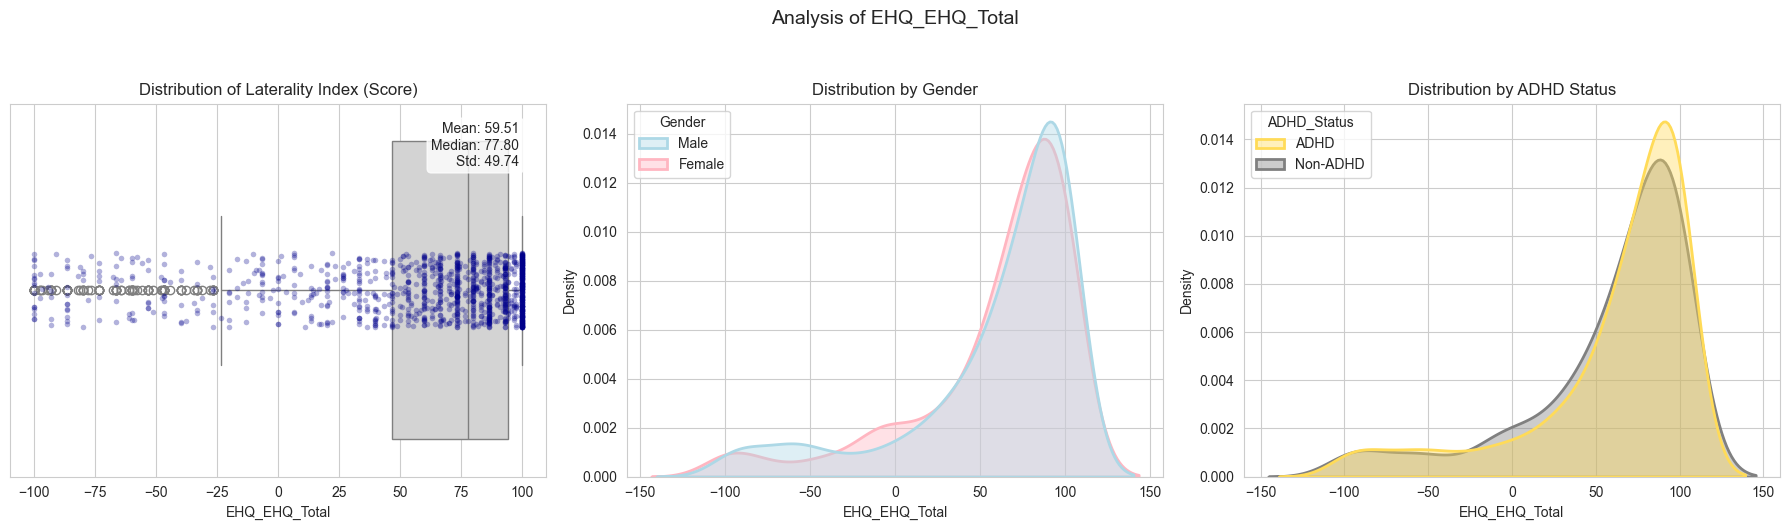

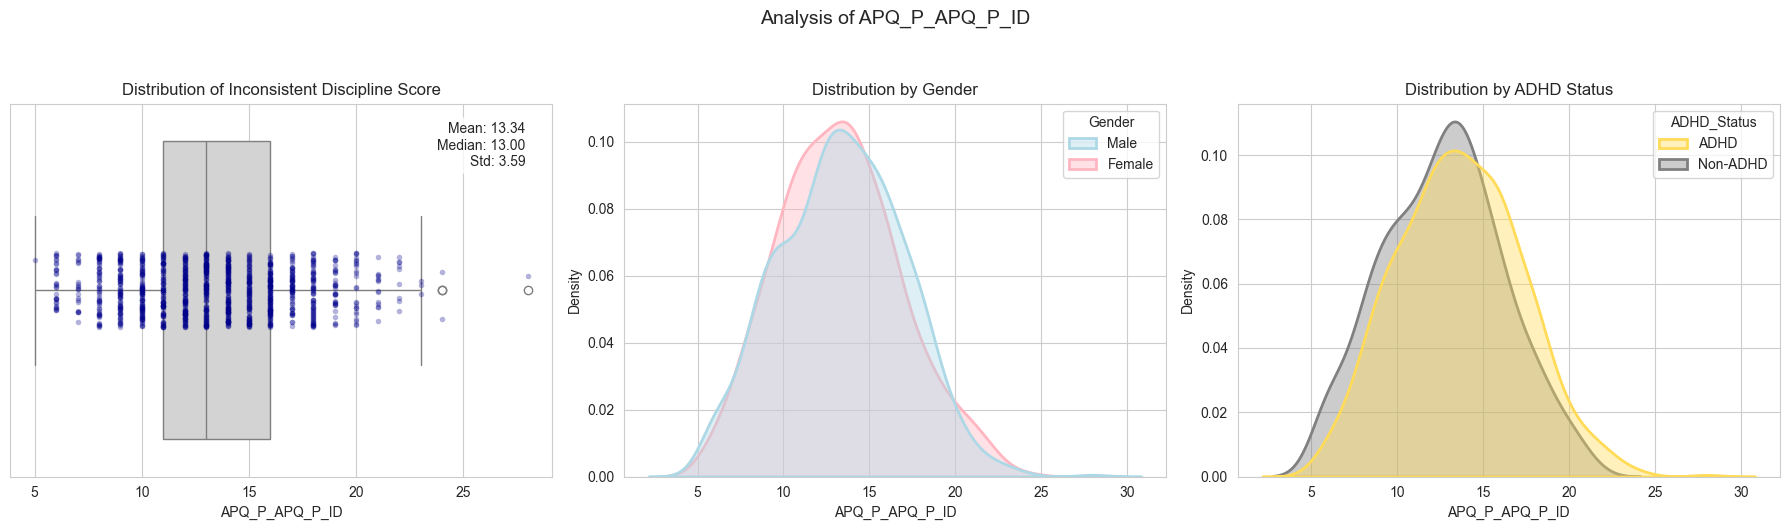

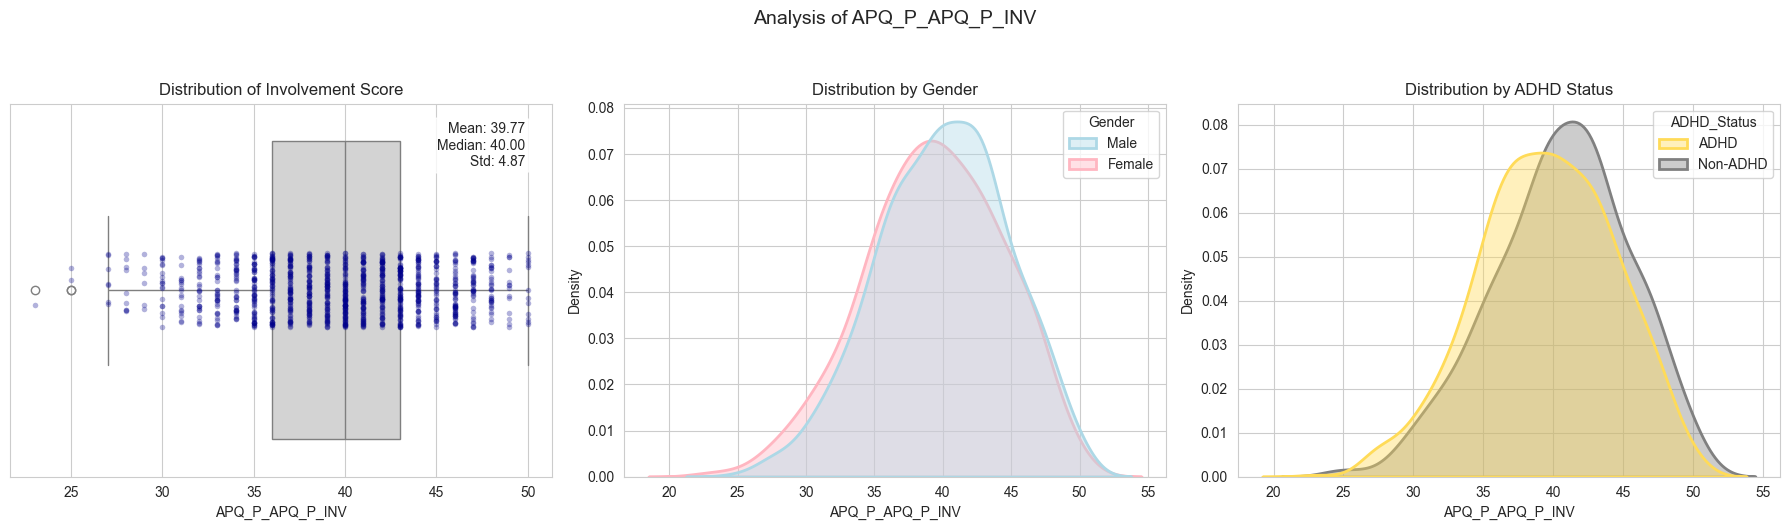

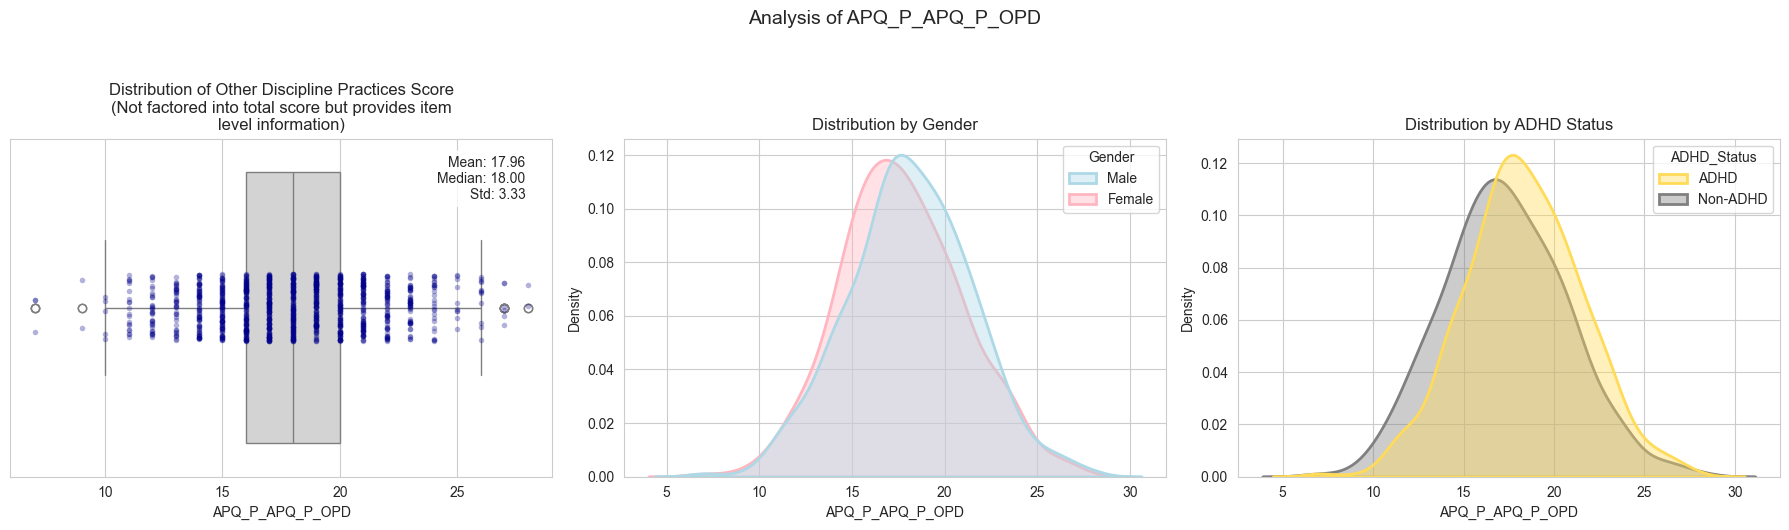

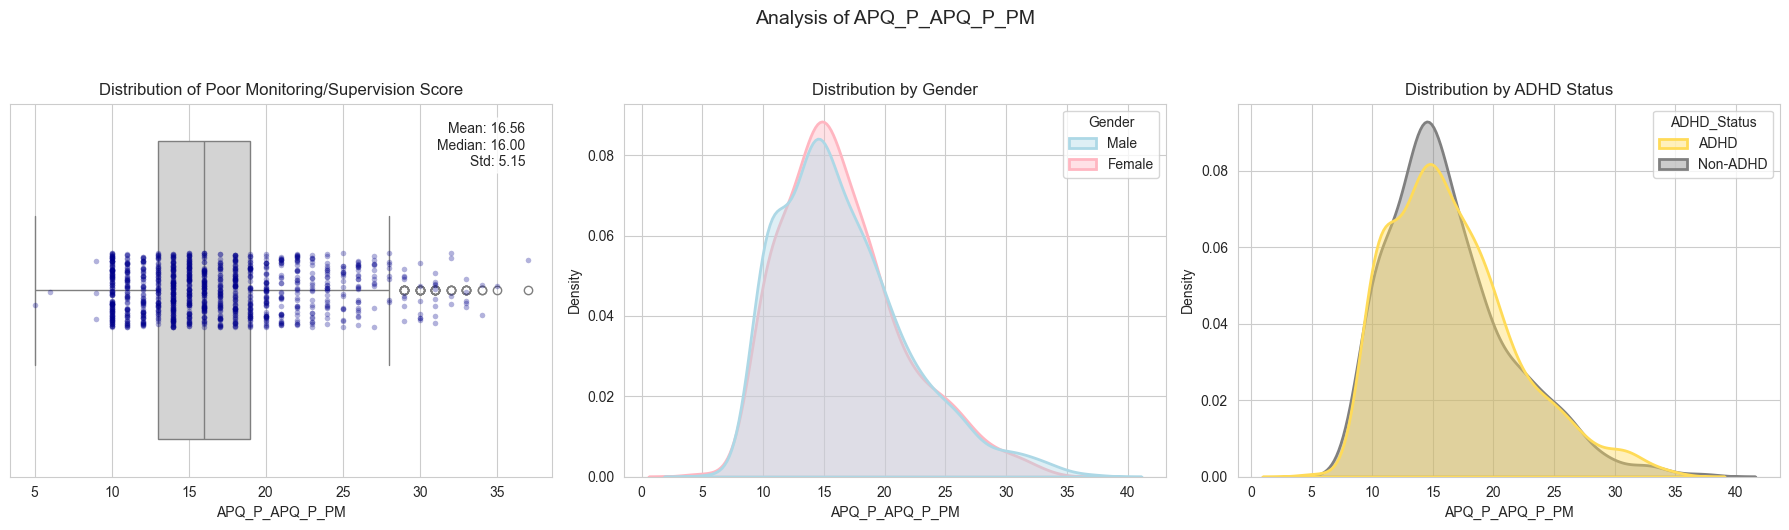

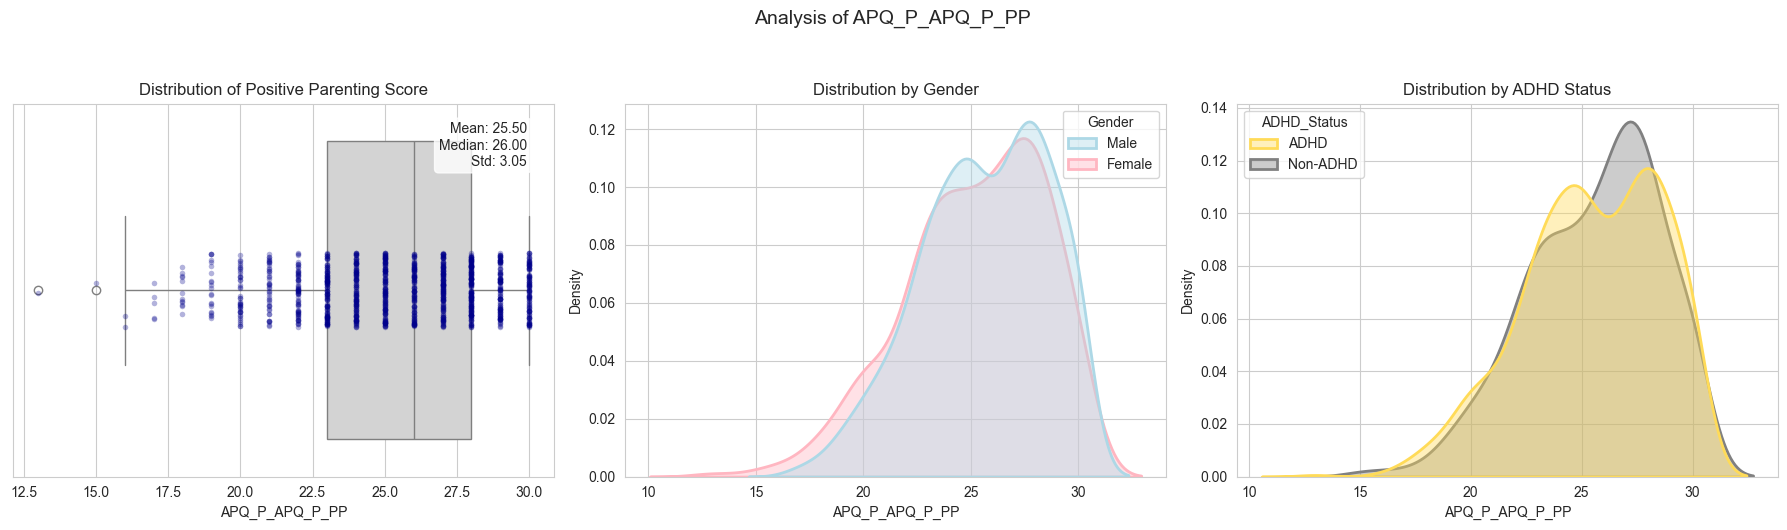

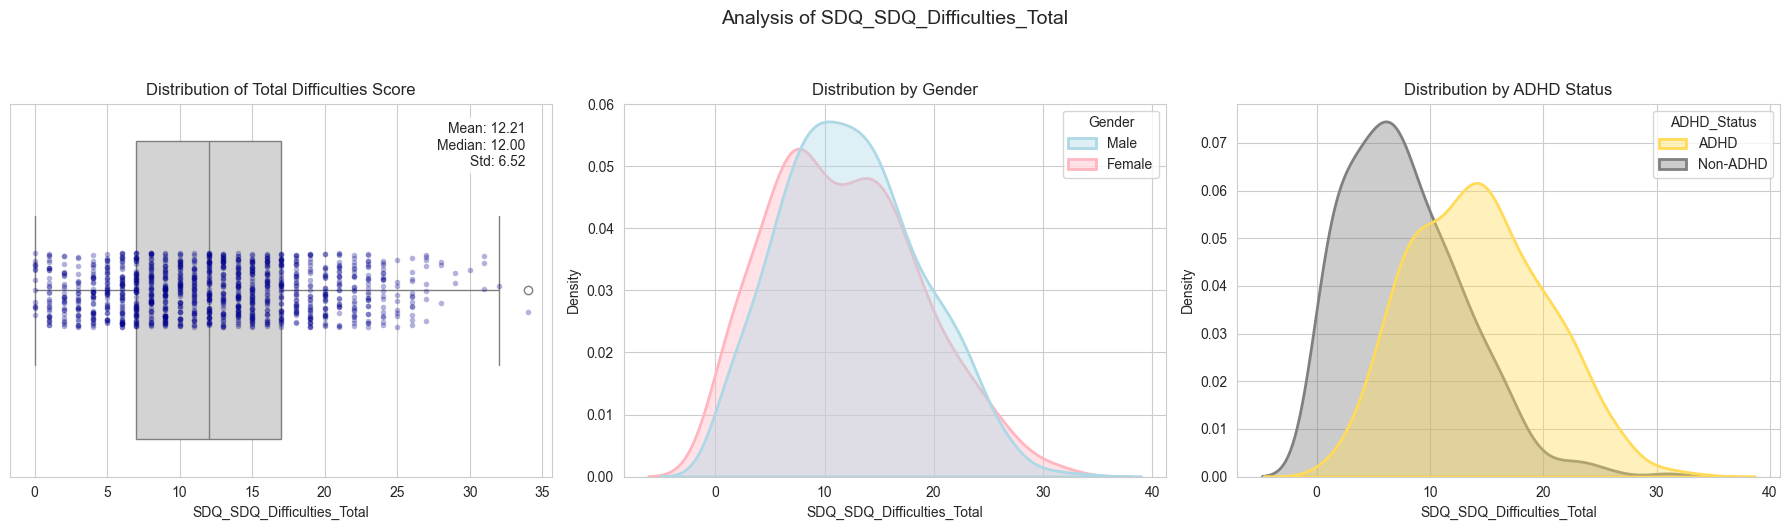

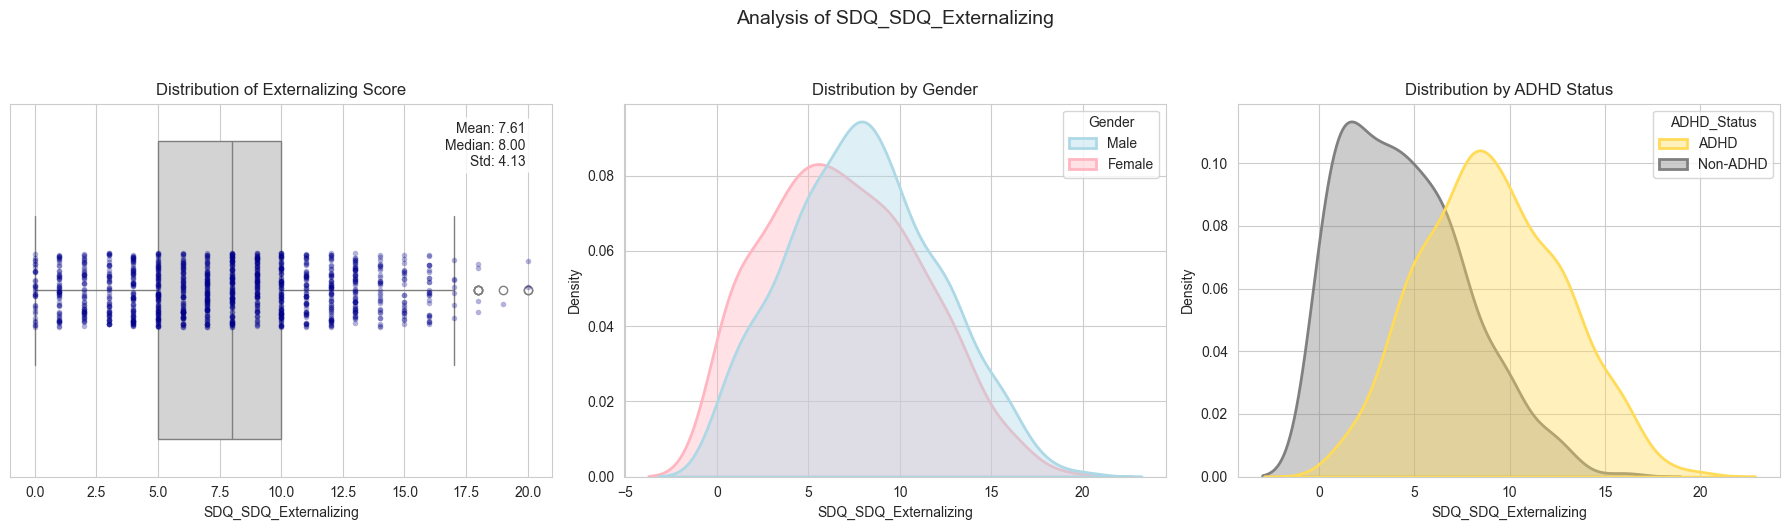

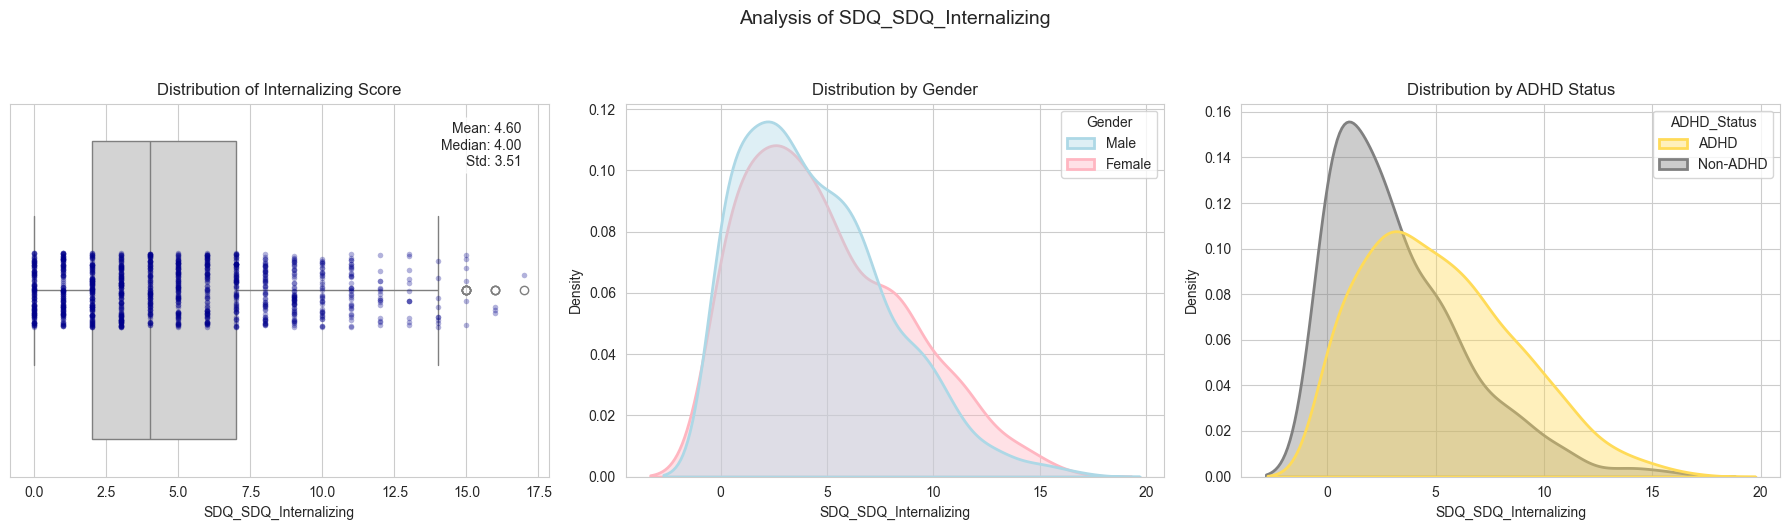

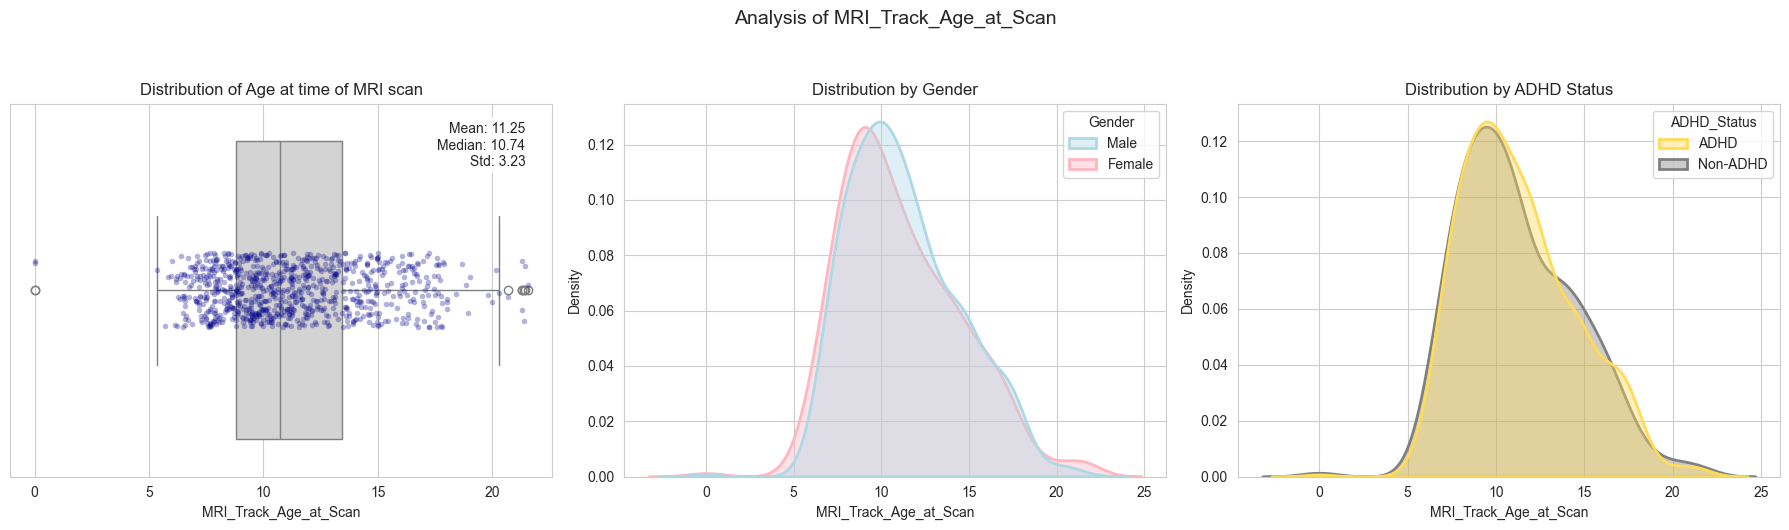

In [36]:
# Define custom color palettes for gender and ADHD status
gender_palette = {"Male": "lightblue", "Female": "lightpink"}
adhd_palette = {"Non-ADHD": "grey", "ADHD": "#FFDB58"}

# Ensure we only analyze the numerical variables
variables = [col for col in overall_df.columns if col in numerical_variables]

# Create new columns for gender and ADHD status if not already present
if 'Gender' not in overall_df.columns:
    overall_df['Gender'] = overall_df['Sex_F'].apply(lambda x: "Female" if x == 1 else "Male")

if 'ADHD_Status' not in overall_df.columns:
    overall_df['ADHD_Status'] = overall_df['ADHD_Outcome'].apply(lambda x: "ADHD" if x == 1 else "Non-ADHD")

# Function to create and display a row of plots for a single variable
def create_numerical_plots(variable):
    sns.set_style('whitegrid')

    # Create a 1x3 subplot: box plot, gender KDE, ADHD KDE
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ---------------------
    # 1. Box plot with individual points
    # ---------------------
    sns.boxplot(ax=axes[0], data=overall_df, x=variable, color='lightgrey')
    sns.stripplot(ax=axes[0], data=overall_df, x=variable, color='darkblue', alpha=0.3, size=4)
    axes[0].set_xlabel(variable)
    title_box = f"Distribution of {dict_df.loc[dict_df['Field'] == variable, 'Description'].values[0]}"
    axes[0].set_title("\n".join(textwrap.wrap(title_box, width=50)))

    # ---------------------
    # 2. KDE Plot by Gender (Male vs Female)
    # ---------------------
    sns.kdeplot(ax=axes[1], data=overall_df, x=variable, hue="Gender", fill=True, 
                common_norm=False, palette=gender_palette, alpha=0.4, linewidth=2)
    axes[1].set_xlabel(variable)
    axes[1].set_title(f"Distribution by Gender")

    # ---------------------
    # 3. KDE Plot by ADHD Status
    # ---------------------
    sns.kdeplot(ax=axes[2], data=overall_df, x=variable, hue="ADHD_Status", fill=True, 
                common_norm=False, palette=adhd_palette, alpha=0.4, linewidth=2)
    axes[2].set_xlabel(variable)
    axes[2].set_title(f"Distribution by ADHD Status")

    # Add descriptive statistics as text
    stats_text = f"Mean: {overall_df[variable].mean():.2f}\n"
    stats_text += f"Median: {overall_df[variable].median():.2f}\n"
    stats_text += f"Std: {overall_df[variable].std():.2f}"
    axes[0].text(0.95, 0.95, stats_text,
                 transform=axes[0].transAxes,
                 verticalalignment='top',
                 horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Adjust spacing and show the plots
    plt.suptitle(f"Analysis of {variable}", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

# Perform univariate analysis for each variable in the list
for variable in variables:
    create_numerical_plots(variable)

# Clean up: Drop the temporary columns after analysis
overall_df.drop(['Gender', 'ADHD_Status'], axis=1, inplace=True)

### Categorical Feature Analysis

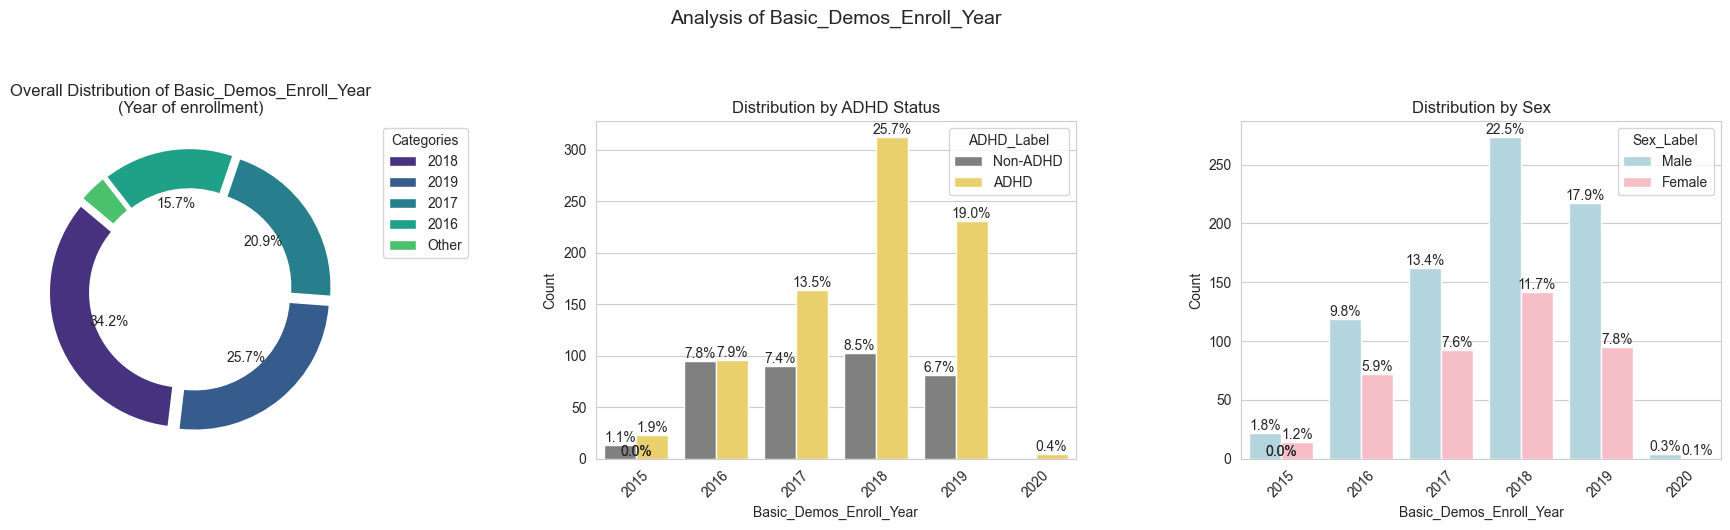


Chi-square Test Results for Basic_Demos_Enroll_Year:
- Association with ADHD: chi2 = 46.94, p = 0.0000
- Association with Sex: chi2 = 4.24, p = 0.5156
--------------------------------------------------


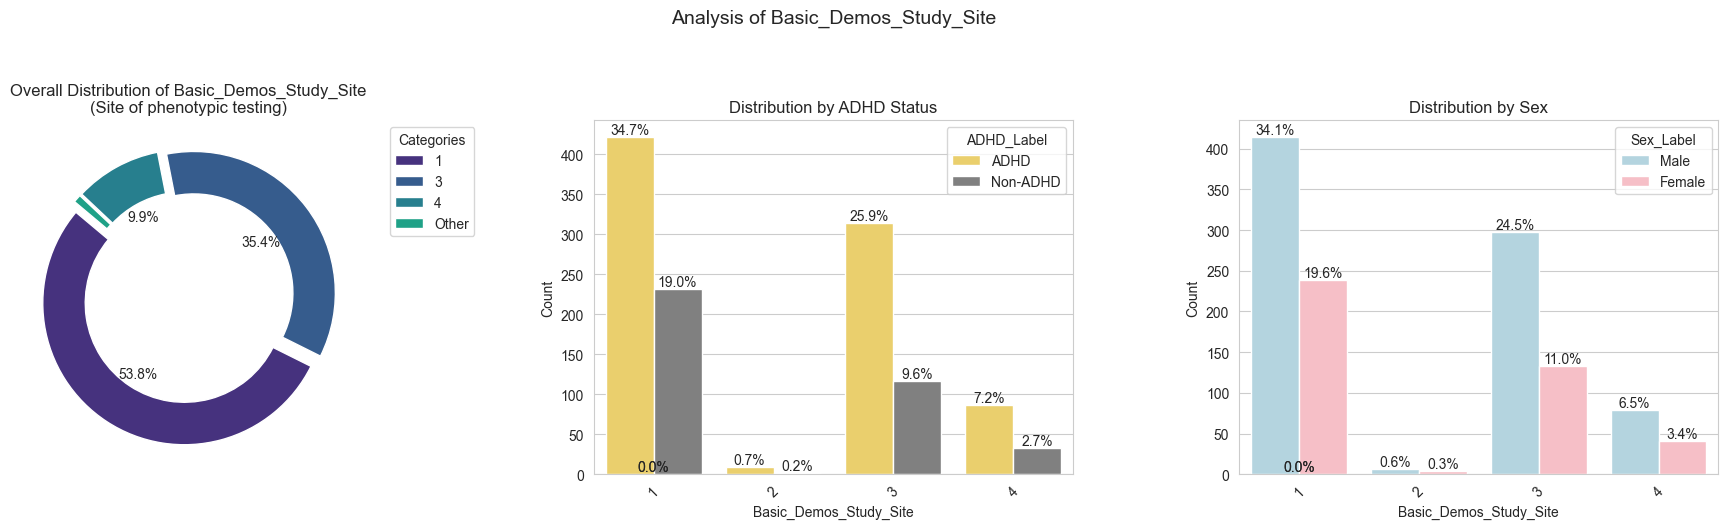


Chi-square Test Results for Basic_Demos_Study_Site:
- Association with ADHD: chi2 = 10.54, p = 0.0145
- Association with Sex: chi2 = 3.59, p = 0.3089
--------------------------------------------------


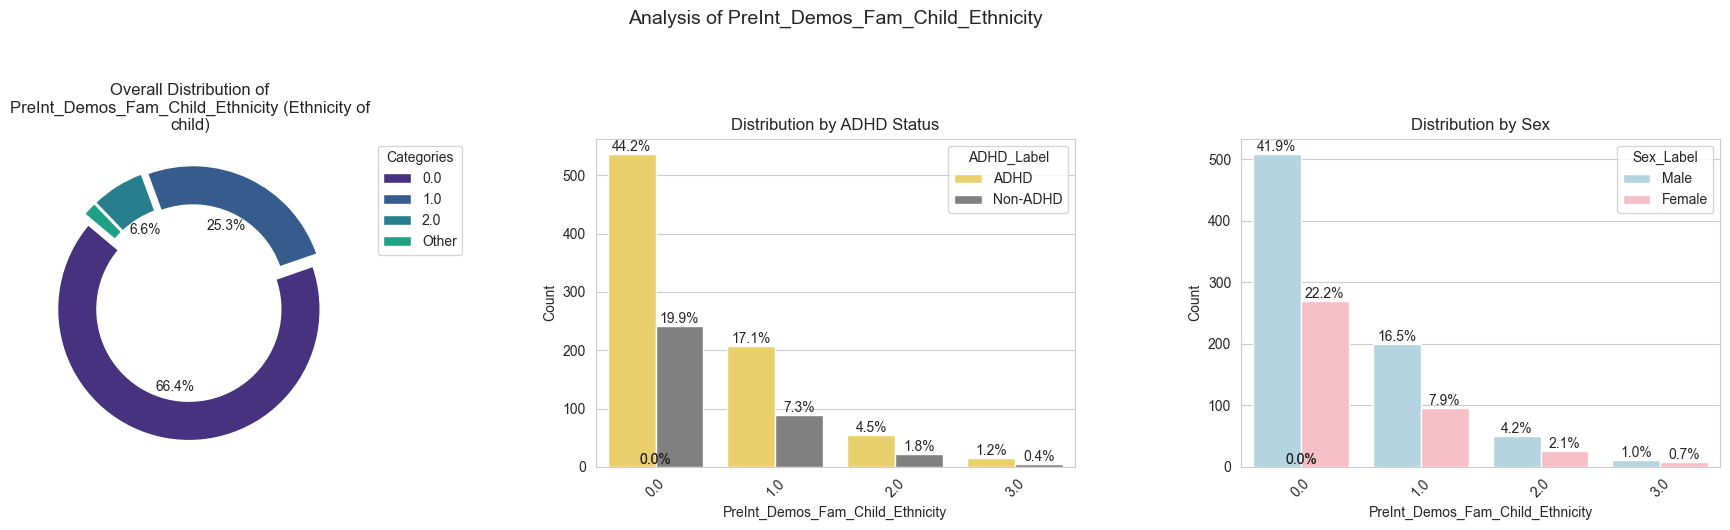


Chi-square Test Results for PreInt_Demos_Fam_Child_Ethnicity:
- Association with ADHD: chi2 = 0.54, p = 0.9091
- Association with Sex: chi2 = 0.77, p = 0.8558
--------------------------------------------------


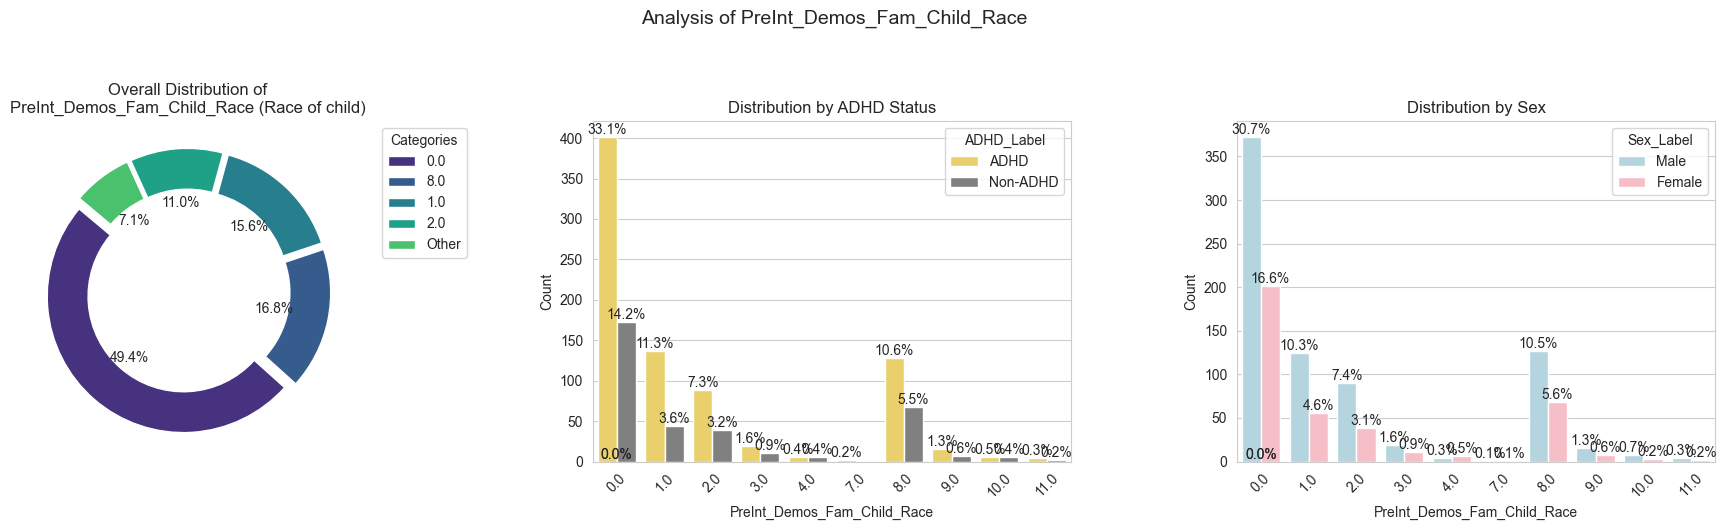


Chi-square Test Results for PreInt_Demos_Fam_Child_Race:
- Association with ADHD: chi2 = 9.11, p = 0.4271
- Association with Sex: chi2 = 5.87, p = 0.7527
--------------------------------------------------


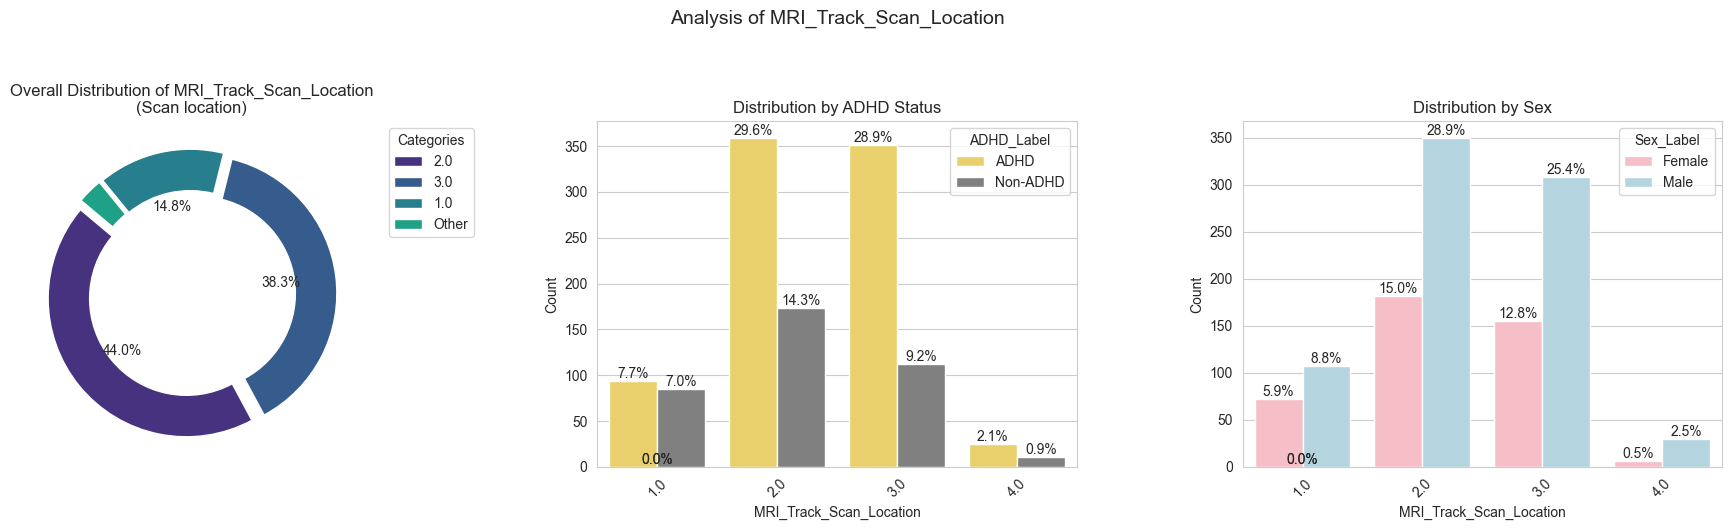


Chi-square Test Results for MRI_Track_Scan_Location:
- Association with ADHD: chi2 = 32.94, p = 0.0000
- Association with Sex: chi2 = 7.90, p = 0.0482
--------------------------------------------------


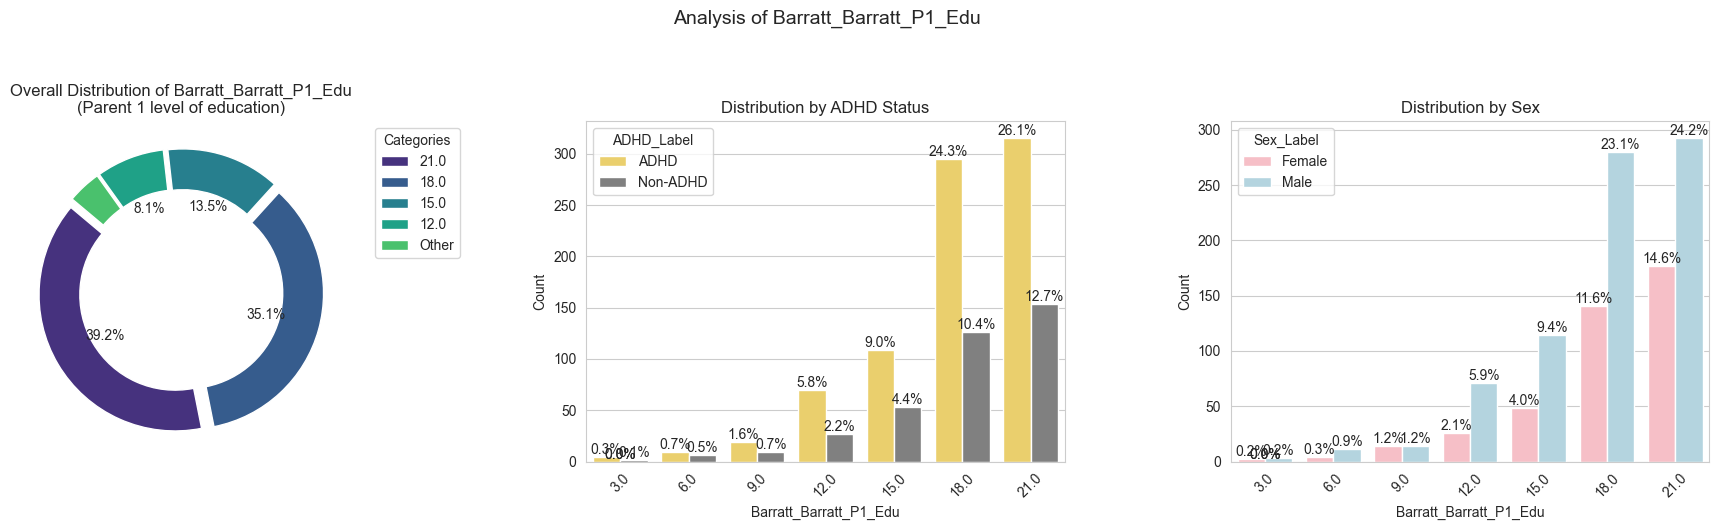


Chi-square Test Results for Barratt_Barratt_P1_Edu:
- Association with ADHD: chi2 = 2.36, p = 0.8841
- Association with Sex: chi2 = 9.97, p = 0.1260
--------------------------------------------------


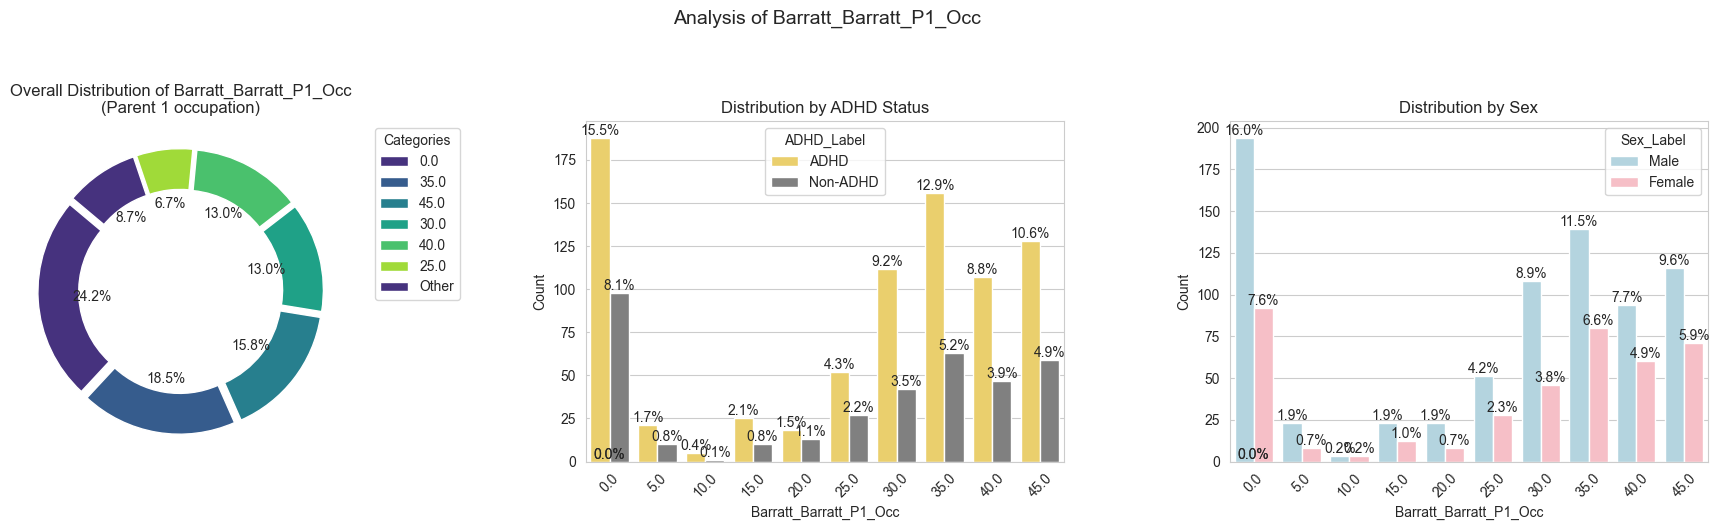


Chi-square Test Results for Barratt_Barratt_P1_Occ:
- Association with ADHD: chi2 = 5.70, p = 0.7695
- Association with Sex: chi2 = 7.64, p = 0.5707
--------------------------------------------------


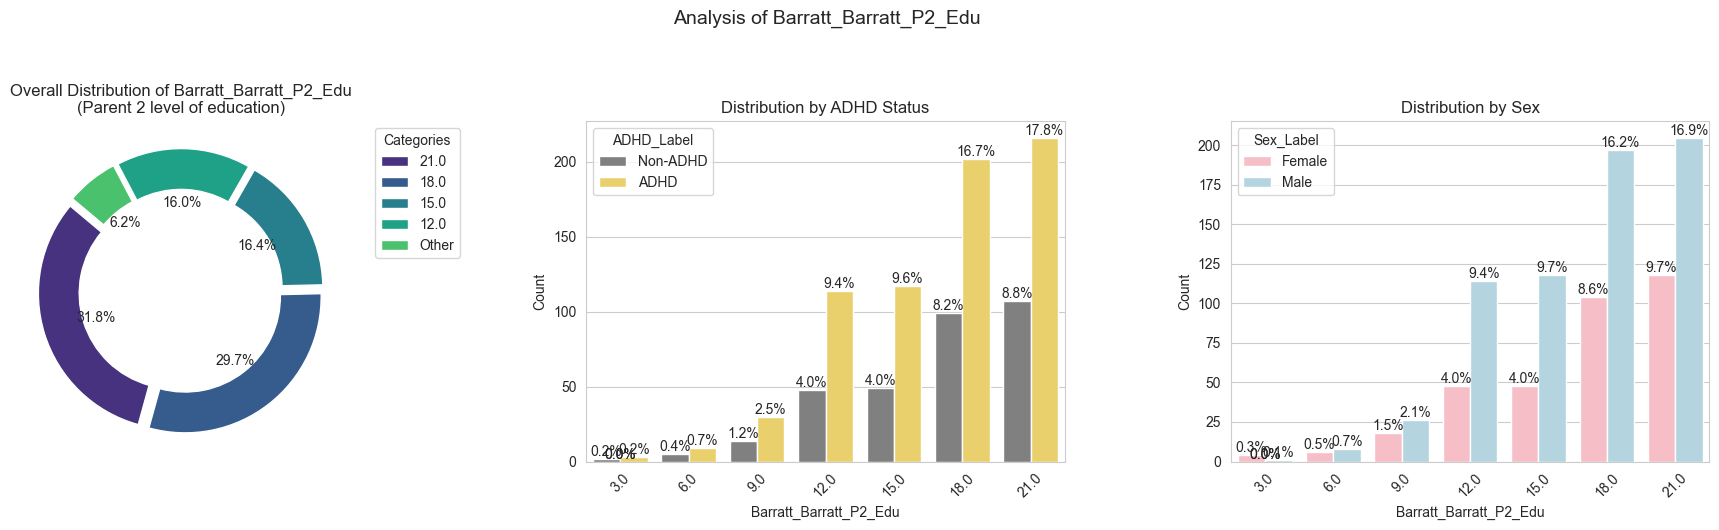


Chi-square Test Results for Barratt_Barratt_P2_Edu:
- Association with ADHD: chi2 = 1.42, p = 0.9645
- Association with Sex: chi2 = 10.38, p = 0.1096
--------------------------------------------------


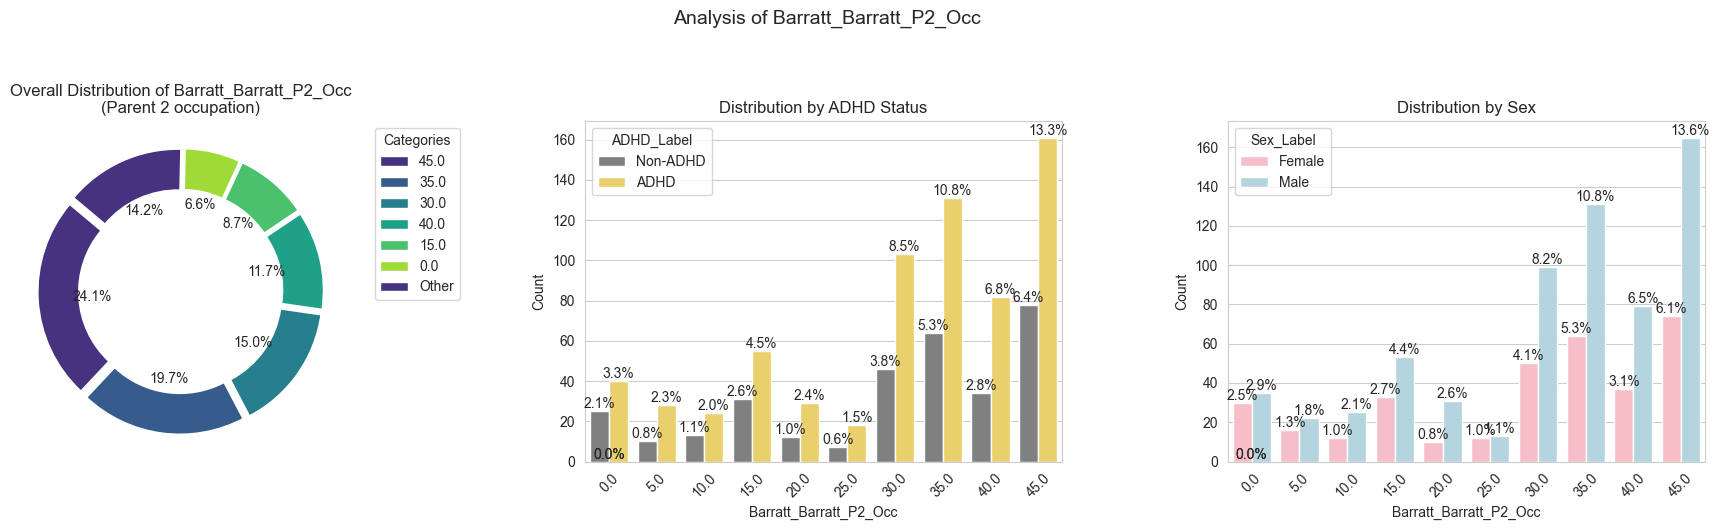


Chi-square Test Results for Barratt_Barratt_P2_Occ:
- Association with ADHD: chi2 = 3.47, p = 0.9426
- Association with Sex: chi2 = 11.36, p = 0.2519
--------------------------------------------------


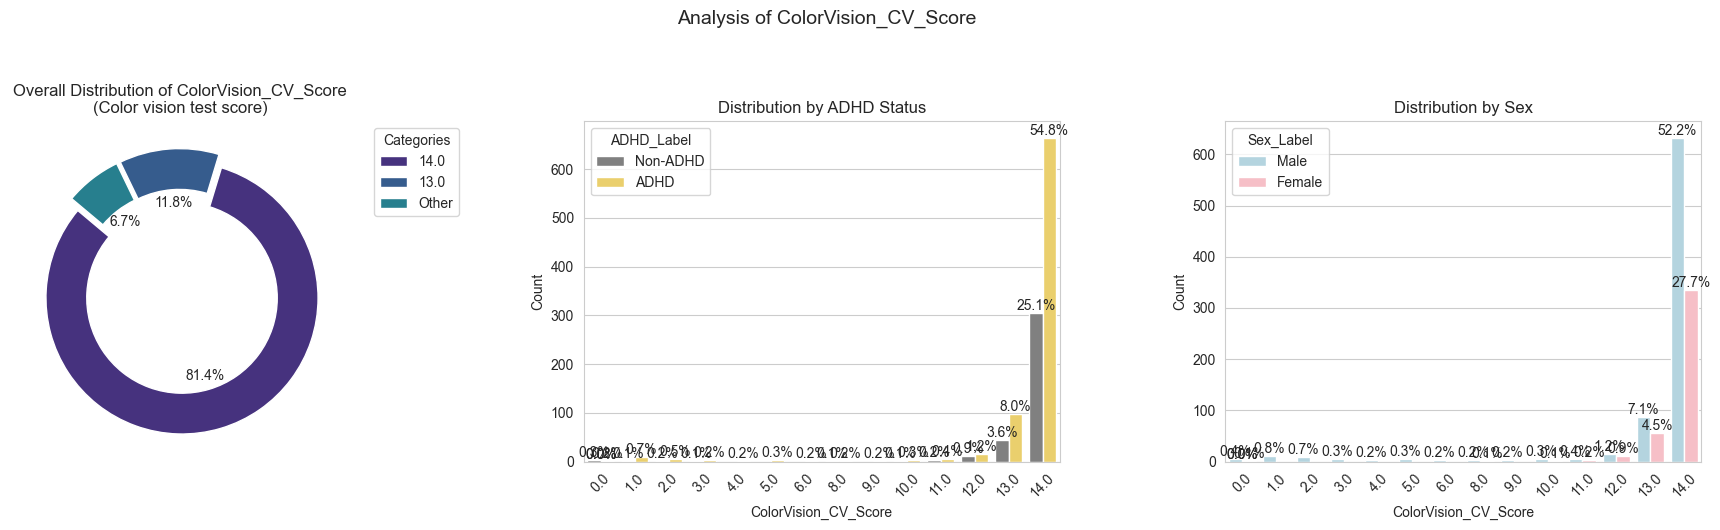


Chi-square Test Results for ColorVision_CV_Score:
- Association with ADHD: chi2 = 12.30, p = 0.5033
- Association with Sex: chi2 = 20.22, p = 0.0900
--------------------------------------------------


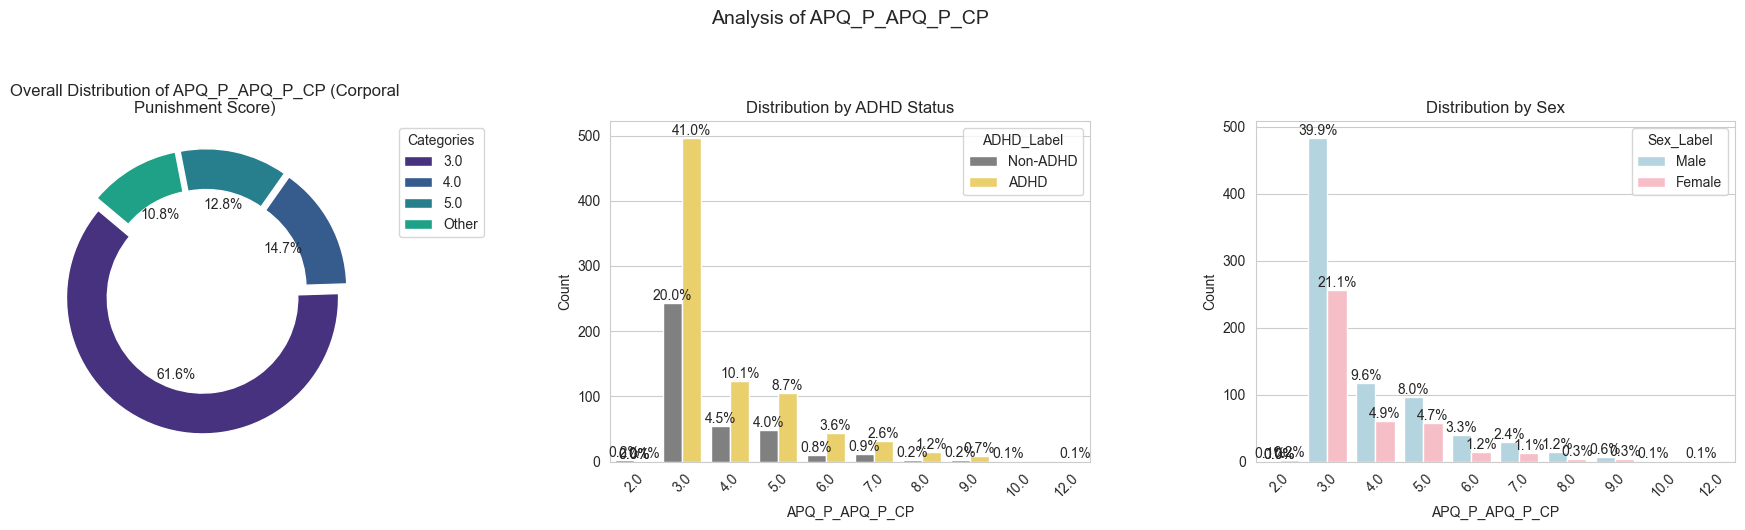


Chi-square Test Results for APQ_P_APQ_P_CP:
- Association with ADHD: chi2 = 11.77, p = 0.2268
- Association with Sex: chi2 = 6.06, p = 0.7341
--------------------------------------------------


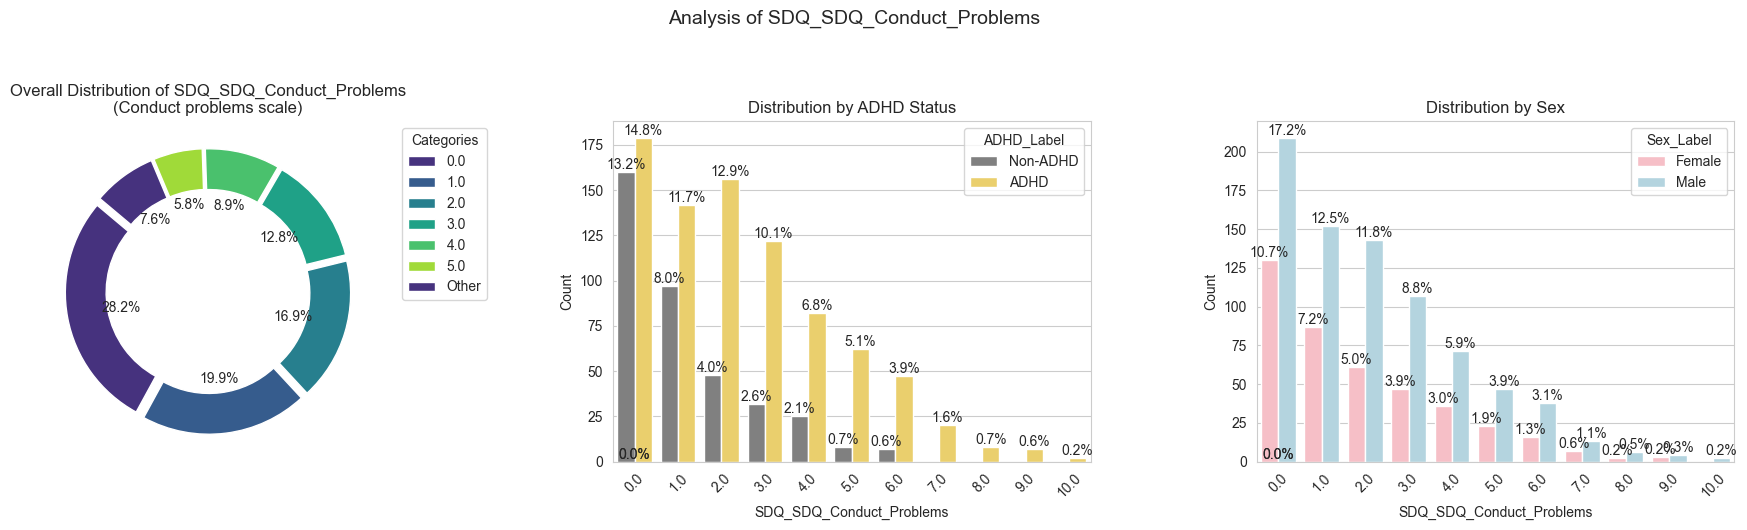


Chi-square Test Results for SDQ_SDQ_Conduct_Problems:
- Association with ADHD: chi2 = 104.35, p = 0.0000
- Association with Sex: chi2 = 7.86, p = 0.6428
--------------------------------------------------


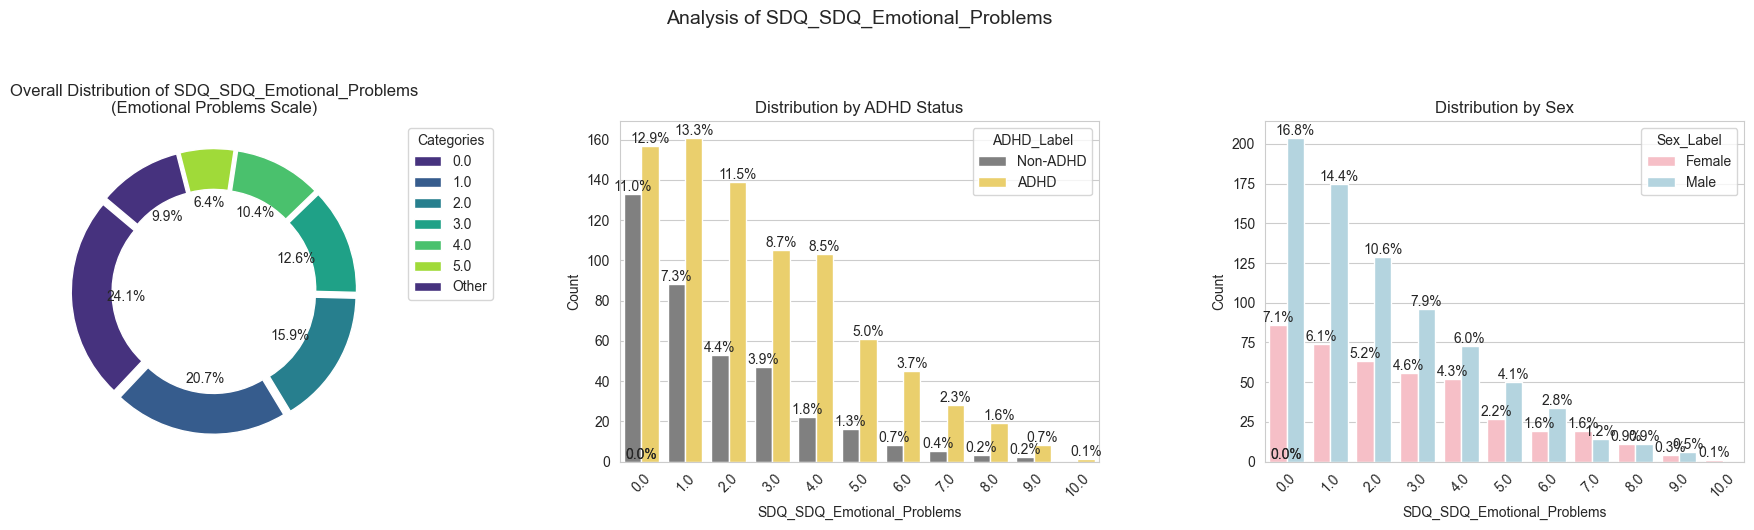


Chi-square Test Results for SDQ_SDQ_Emotional_Problems:
- Association with ADHD: chi2 = 61.30, p = 0.0000
- Association with Sex: chi2 = 21.17, p = 0.0199
--------------------------------------------------


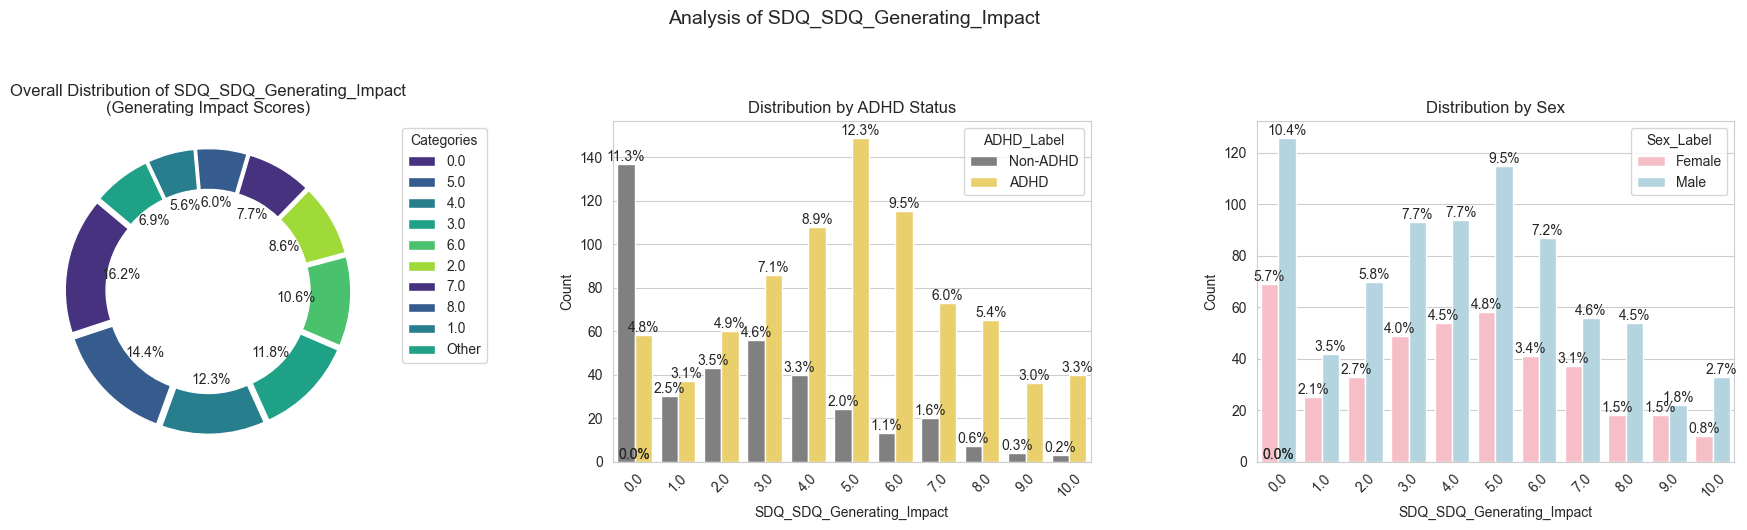


Chi-square Test Results for SDQ_SDQ_Generating_Impact:
- Association with ADHD: chi2 = 245.14, p = 0.0000
- Association with Sex: chi2 = 9.63, p = 0.4733
--------------------------------------------------


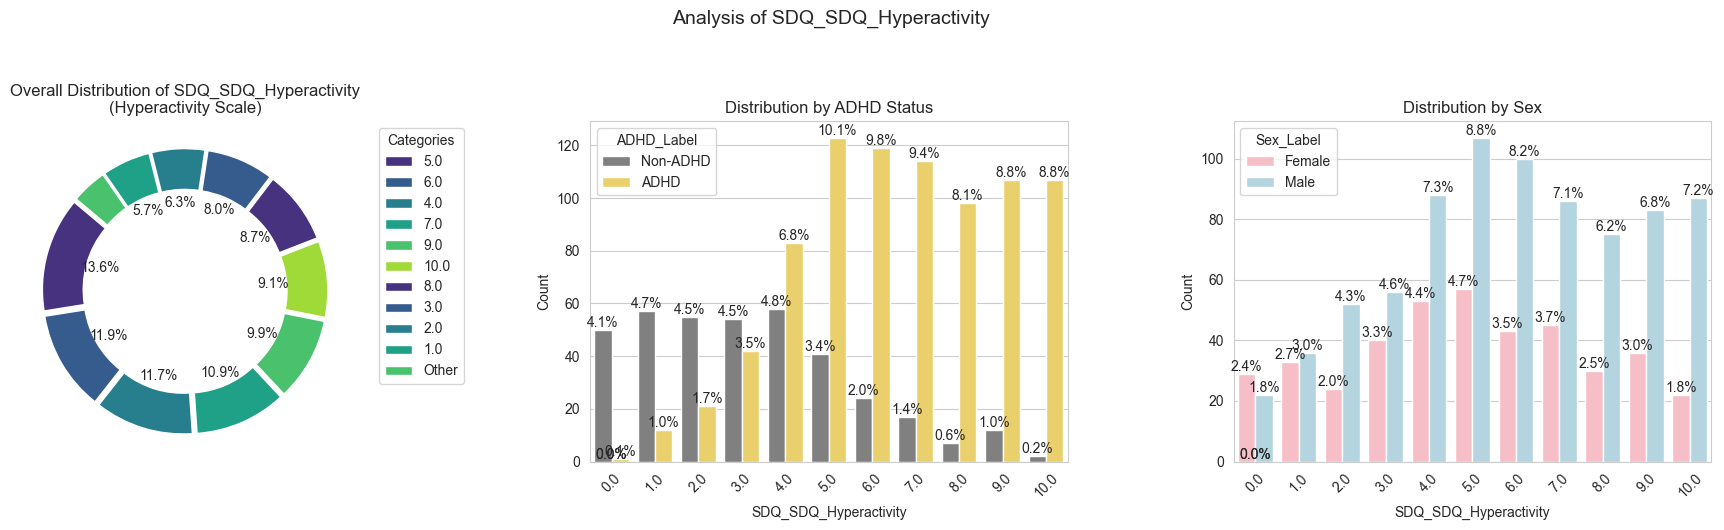


Chi-square Test Results for SDQ_SDQ_Hyperactivity:
- Association with ADHD: chi2 = 419.82, p = 0.0000
- Association with Sex: chi2 = 33.58, p = 0.0002
--------------------------------------------------


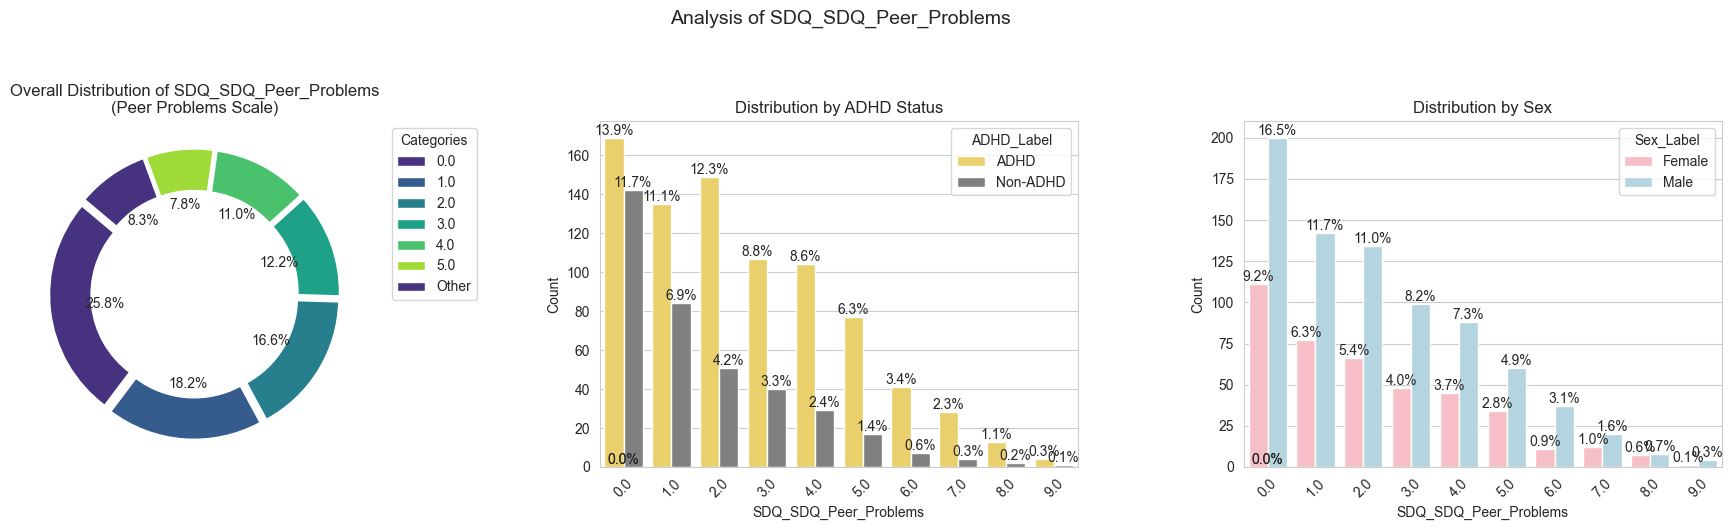


Chi-square Test Results for SDQ_SDQ_Peer_Problems:
- Association with ADHD: chi2 = 66.41, p = 0.0000
- Association with Sex: chi2 = 5.20, p = 0.8162
--------------------------------------------------


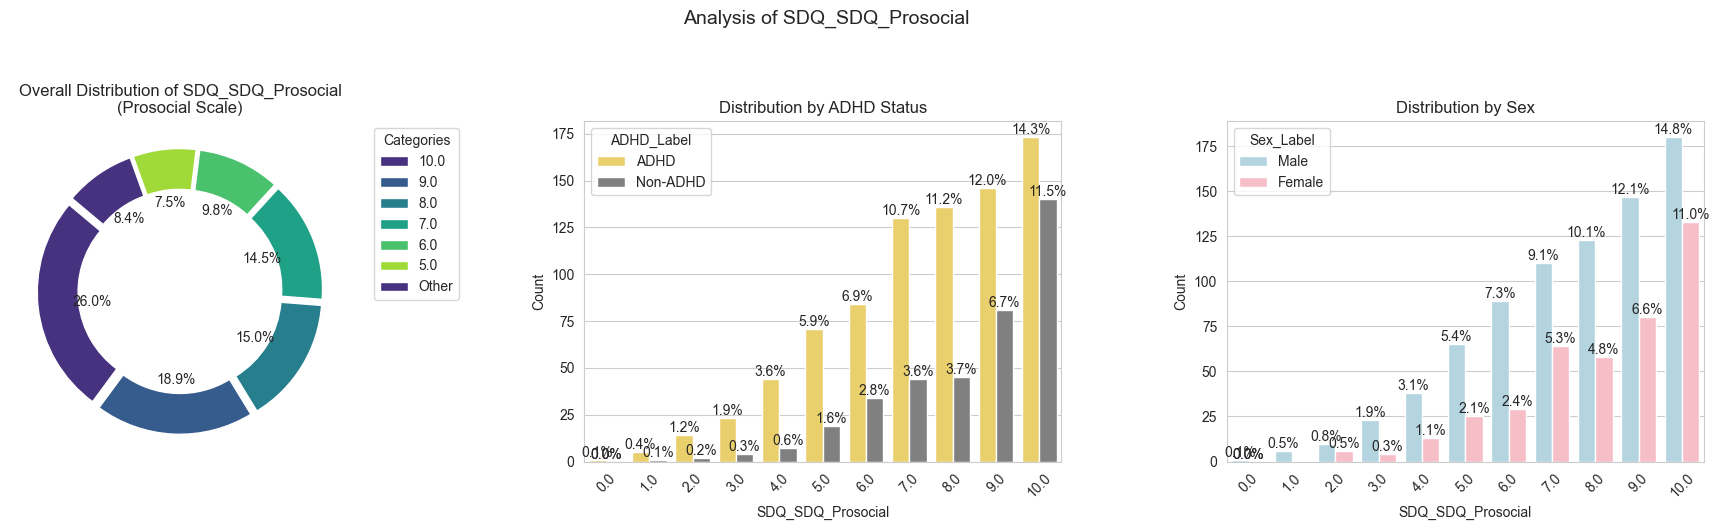


Chi-square Test Results for SDQ_SDQ_Prosocial:
- Association with ADHD: chi2 = 53.78, p = 0.0000
- Association with Sex: chi2 = 27.00, p = 0.0026
--------------------------------------------------


In [35]:
# Define color palettes
adhd_palette = {"Non-ADHD": "grey", "ADHD": "#FFDB58"}
gender_palette = {"Male": "lightblue", "Female": "lightpink"}
pie_palette = sns.color_palette("viridis")  # For pie chart segments

def create_categorical_plots(feature):
    sns.set_style('whitegrid')

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ---------------------
    # Plot 1: Overall Pie Chart
    # ---------------------
    value_counts = overall_df[feature].value_counts()
    threshold = 0.05 * value_counts.sum()  # 5% threshold
    filtered_values = value_counts[value_counts >= threshold]
    if value_counts[value_counts < threshold].sum() > 0:
        filtered_values['Other'] = value_counts[value_counts < threshold].sum()

    wedges, texts, autotexts = axes[0].pie(
        filtered_values,
        autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
        colors=pie_palette[:len(filtered_values)],
        startangle=140,
        wedgeprops=dict(width=0.3),
        explode=[0.05] * len(filtered_values),
        textprops={'fontsize': 10}
    )
    
    # Add feature description from data dictionary
    title = f"Overall Distribution of {feature}"
    if feature in dict_df['Field'].values:
        description = dict_df.loc[dict_df['Field'] == feature, 'Description'].values[0]
        title += f"\n({description})"
    axes[0].set_title("\n".join(textwrap.wrap(title, width=50)))
    
    # Add legend
    axes[0].legend(filtered_values.index, 
                  title="Categories",
                  bbox_to_anchor=(1.05, 1),
                  loc='upper left')

    # ---------------------
    # Plot 2: Distribution by ADHD Status
    # ---------------------
    # Create ADHD labels
    overall_df['ADHD_Label'] = overall_df['ADHD_Outcome'].map({0: "Non-ADHD", 1: "ADHD"})
    
    sns.countplot(
        data=overall_df,
        x=feature,
        hue='ADHD_Label',
        palette=adhd_palette,
        ax=axes[1]
    )
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel("Count")
    axes[1].set_title("Distribution by ADHD Status")
    axes[1].tick_params(axis='x', rotation=45)

    # Add percentage annotations
    total = len(overall_df)
    for p in axes[1].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        axes[1].annotate(percentage,
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

    # ---------------------
    # Plot 3: Distribution by Sex
    # ---------------------
    # Create sex labels
    overall_df['Sex_Label'] = overall_df['Sex_F'].map({0: "Male", 1: "Female"})
    
    sns.countplot(
        data=overall_df,
        x=feature,
        hue='Sex_Label',
        palette=gender_palette,
        ax=axes[2]
    )
    axes[2].set_xlabel(feature)
    axes[2].set_ylabel("Count")
    axes[2].set_title("Distribution by Sex")
    axes[2].tick_params(axis='x', rotation=45)

    # Add percentage annotations
    for p in axes[2].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        axes[2].annotate(percentage,
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')

    # Adjust layout and display
    plt.suptitle(f"Analysis of {feature}", y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print chi-square test results
    print(f"\nChi-square Test Results for {feature}:")
    # Test association with ADHD
    adhd_ct = pd.crosstab(overall_df[feature], overall_df['ADHD_Label'])
    chi2_adhd, p_adhd = stats.chi2_contingency(adhd_ct)[:2]
    print(f"- Association with ADHD: chi2 = {chi2_adhd:.2f}, p = {p_adhd:.4f}")
    
    # Test association with Sex
    sex_ct = pd.crosstab(overall_df[feature], overall_df['Sex_Label'])
    chi2_sex, p_sex = stats.chi2_contingency(sex_ct)[:2]
    print(f"- Association with Sex: chi2 = {chi2_sex:.2f}, p = {p_sex:.4f}")
    print("-" * 50)

# Perform univariate analysis for each categorical variable
for feature in categorical_variables:
    create_categorical_plots(feature)

# Cleanup: Drop temporary columns
overall_df.drop(['ADHD_Label', 'Sex_Label'], axis=1, inplace=True)

### Target Feature Analysis

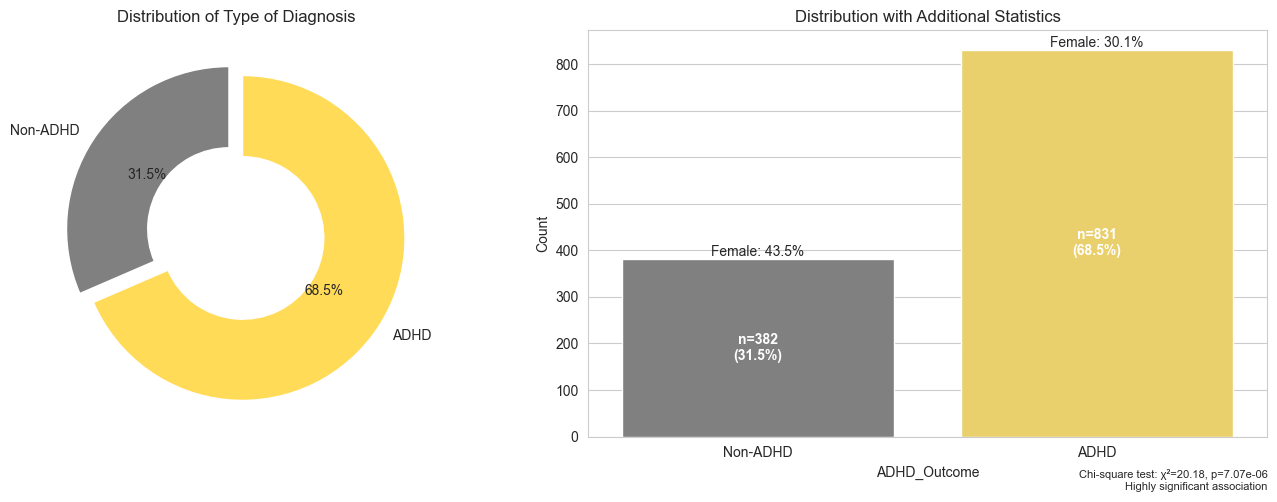


Summary Statistics for ADHD_Outcome:
Total samples: 1213
Non-ADHD: n=382 (31.5%) - Female rate: 43.5%
ADHD: n=831 (68.5%) - Female rate: 30.1%
--------------------------------------------------


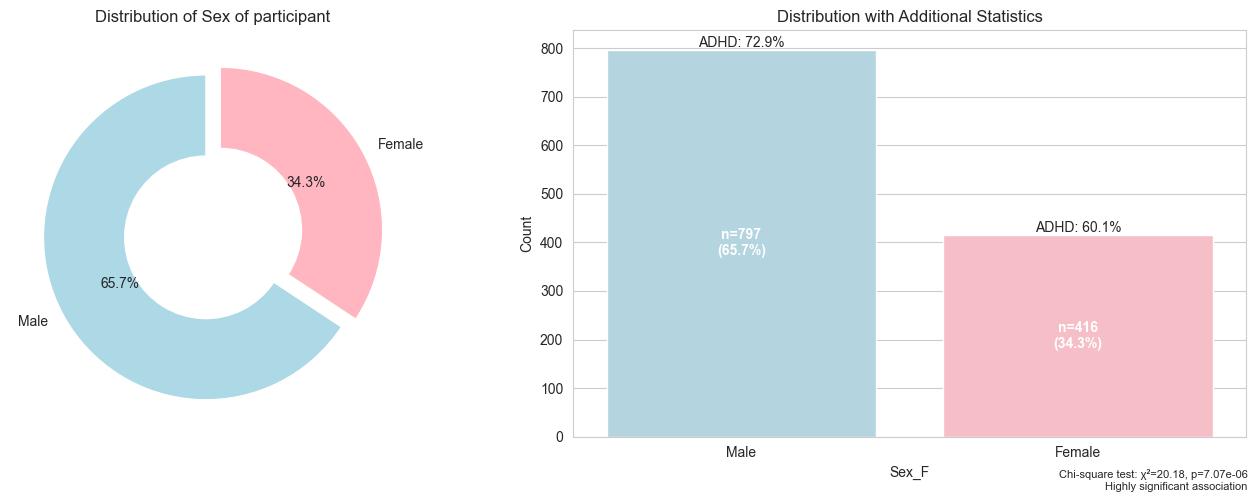


Summary Statistics for Sex_F:
Total samples: 1213
Male: n=797 (65.7%) - ADHD rate: 72.9%
Female: n=416 (34.3%) - ADHD rate: 60.1%
--------------------------------------------------


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap
from scipy import stats

# Define color palettes for target variables
sex_color_map = {0: 'lightblue', 1: 'lightpink'}
adhd_color_map = {0: 'grey', 1: '#FFDB58'}

# Labels for better visualization
sex_labels = {0: "Male", 1: "Female"}
adhd_labels = {0: "Non-ADHD", 1: "ADHD"}

def create_categorical_plots(variable):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Get value counts from overall_df
    value_counts = overall_df[variable].value_counts().sort_index()
    total = len(overall_df)

    # ---------------------
    # Plot 1: Pie Chart
    # ---------------------
    # Set appropriate color map and labels
    if variable == 'Sex_F':
        order = [0, 1]  # Male then Female
        value_counts = value_counts.reindex(order).dropna()
        colors = [sex_color_map[val] for val in order]
        labels = [sex_labels[val] for val in order]
        color_map = sex_color_map
    else:  # ADHD_Outcome
        order = [0, 1]  # Non-ADHD then ADHD
        value_counts = value_counts.reindex(order).dropna()
        colors = [adhd_color_map[val] for val in order]
        labels = [adhd_labels[val] for val in order]
        color_map = adhd_color_map

    wedges, texts, autotexts = axes[0].pie(
        value_counts,
        labels=labels,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        wedgeprops=dict(width=0.5),
        explode=[0.05] * len(value_counts)
    )

    title_text = dict_df.loc[dict_df['Field'] == variable, 'Description'].values[0] \
                    if variable in dict_df['Field'].values else variable
    axes[0].set_title(f"Distribution of {title_text}")

    # ---------------------
    # Plot 2: Bar Plot with Additional Statistics
    # ---------------------
    # Convert data for plotting
    plot_data = overall_df.copy()
    
    # Create the countplot with integer values
    if variable == 'Sex_F':
        sns.countplot(
            data=plot_data,
            x=variable,
            ax=axes[1],
            order=order,
            palette=[sex_color_map[i] for i in order]  # color for corresponding sex
        )
        axes[1].set_xticklabels(['Male', 'Female'])
    else:  # ADHD_Outcome
        sns.countplot(
            data=plot_data,
            x=variable,
            ax=axes[1],
            order=order,
            palette=[adhd_color_map[i] for i in order]  # color for corresponding adhd outcome
        )
        axes[1].set_xticklabels(['Non-ADHD', 'ADHD'])

        
    # Add specific statistics based on variable type
    if variable == 'Sex_F':
        for i, gender in enumerate(order):
            gender_subset = plot_data[plot_data['Sex_F'] == gender]
            adhd_cases = len(gender_subset[gender_subset['ADHD_Outcome'] == 1])
            adhd_pct = (adhd_cases / len(gender_subset)) * 100
            
            axes[1].text(i, value_counts[gender],
                        f'ADHD: {adhd_pct:.1f}%',
                        ha='center', va='bottom')
        axes[1].set_xticklabels(['Male', 'Female'])
    else:  # ADHD_Outcome
        for i, status in enumerate(order):
            status_subset = plot_data[plot_data['ADHD_Outcome'] == status]
            female_cases = len(status_subset[status_subset['Sex_F'] == 1])
            female_pct = (female_cases / len(status_subset)) * 100
            
            axes[1].text(i, value_counts[status],
                        f'Female: {female_pct:.1f}%',
                        ha='center', va='bottom')
        axes[1].set_xticklabels(['Non-ADHD', 'ADHD'])

    # Add count and percentage labels on bars
    for i, v in enumerate(value_counts):
        axes[1].text(i, v/2, 
                    f'n={v}\n({v/total*100:.1f}%)',
                    ha='center', va='center',
                    color='white',
                    fontweight='bold')

    axes[1].set_ylabel("Count")
    axes[1].set_title("Distribution with Additional Statistics")

    # Add chi-square test result
    contingency_table = pd.crosstab(plot_data['Sex_F'], plot_data['ADHD_Outcome'])
    chi2, p_value = stats.chi2_contingency(contingency_table)[0:2]

    test_result = f'Chi-square test: χ²={chi2:.2f}, p={p_value:.2e}'  # p-value in scientific notation
    if p_value < 0.001:
        test_result += '\nHighly significant association'
    elif p_value < 0.05:
        test_result += '\nSignificant association'
    else:
        test_result += '\nNo significant association'
    
    plt.figtext(0.99, 0.01, 
            test_result,
            ha='right', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics for {variable}:")
    print(f"Total samples: {total}")
    for val in order:
        count = value_counts[val]
        pct = count/total*100
        if variable == 'Sex_F':
            label = sex_labels[val]
            subset = plot_data[plot_data['Sex_F'] == val]
            adhd_count = len(subset[subset['ADHD_Outcome'] == 1])
            adhd_pct = (adhd_count / len(subset)) * 100
            print(f"{label}: n={count} ({pct:.1f}%) - ADHD rate: {adhd_pct:.1f}%")
        else:
            label = adhd_labels[val]
            subset = plot_data[plot_data['ADHD_Outcome'] == val]
            female_count = len(subset[subset['Sex_F'] == 1])
            female_pct = (female_count / len(subset)) * 100
            print(f"{label}: n={count} ({pct:.1f}%) - Female rate: {female_pct:.1f}%")
    print("-" * 50)

# Analyze each target variable
for variable in target_variables:
    create_categorical_plots(variable)